### 1. Design the architecture

Recall the Graph I of desire, there has been two components including subject and the Other.

<div style="text-align:center;">
    <img src="illustrations/fig1.png"  style="width:300px;">
</div>

The Other, as ‘treasures of signifier’ interprets the intention of individual (denoted as Δ) retrospectively (from S2 to S1), making the individual a (barred) subject. This bar indicates that the subject is actually unconsciously shaped by the Other, essentially being a divided subject. Therefore, the architechture of our simulation is designed as the following illustration.

<div style="text-align:center;">
    <img src="illustrations/fig2.png"  style="width:400px;">
</div>

The intention of the individual, as input, is processed by a multi-layer perceptron （MLP） and then the linguistic representation of the intention is generated. The ChatGPT receives the output of mlp and interprets it. At the end of loop, free energy is calculated and defined as the loss function.

As shown in the architecture, there are two free energy items. The first item (denoted as FE1) is calculated based on outputs of MLP and ChatGPT, presenting the differences of two models. The second item (FE2) is calculated based on input of MLP and response of ChatGPT, presenting the differences of the individual's intention and feedback of environment. Obviously, the basic objection of communication is get what the individual want, i.e. the minimal FE2. To minize FE2, the individual must optimize the MLP to precisely express to the Other what he want, i.e. the minimal FE1. This is why we say "So, our focus is not on general communication, but rather on the process of gradually mastering language through the optimization of free energy, in other words, entering the Symbolic register, which is not only an issue of language, but always related to the demand and intention in real world" in our article. 

In this simulation, we aim to teach the MLP some basic linguistic representation to express needs from scracth based on free energy principle and supervised by ChatGPT.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from pymdp.maths import spm_log_single as log_stable
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from openai import OpenAI
import random


### 2. Set up the ChatGPT


In [2]:
# authorization
client = OpenAI(
    base_url="https://oneapi.xty.app/v1",
    api_key="sk-ykouqpo2aV9puc2xEe70Fc6a9c564321A279732507D992D8"
)

def chatgpt(prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are the mother of an infant. Your baby can only speak some words and cries without meaning because he doesn't master the language totally. Here is the list that the infant want: ['mama', 'cat', 'ball']. To interact with the baby and teach him language, you should output two same words, the first is what the baby should have said, the second is what the baby wants. Make sure sample from this list: ['mama', 'cat', 'ball']. #For example, if the infant said 'cat', you might say 'sweety, you want a cat? Here comes the cat!'"},
        {"role": "user", "content": prompt}
        ]
        )
    # Extracting the content from the response
    first_choice = completion.choices[0]
    first_message = first_choice.message
    message_content = first_message.content
    return(message_content)


def chatgpt_random(prompt):
    random_element = random.choice(['mama', 'cat', 'ball'])

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": f"You are the mother of an infant. Your baby can only speak some words and cries without meaning because he doesn't master the language totally. To interact with the baby and teach him language, you should output two words, the first is what the baby should have said, the second is what the baby want. Make sure you generate different response every time, you must sample randomly from this list: ['mama', 'cat', 'ball']. The baby's needs in this turn is '{random_element}', you should also give him the same thing '{random_element}'. #For example, when the needs is cat, you could say 'sweety, you want a cat? Here comes the cat!'. "},
            {"role": "user", "content": prompt}
        ]
    )
    first_choice = completion.choices[0]
    first_message = first_choice.message
    message_content = first_message.content
    return(message_content)


def chatgpt_extract(prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "The given sentence is that a mother responds to her infant's vague language. You should extract and output only two single words from the sentence, the first is what the baby should have said, the second is what the baby want. Make sure 1.these two words you extract exactly exists in this list: ['mama','cat','ball']. 2. must single word. #For example: if the input is Sweetie, did you mean cat? Let's play with the cat!, you should output 'cat, cat'."},
        {"role": "user", "content": prompt}
        ]
        )
    # Extracting the content from the response
    first_choice = completion.choices[0]
    first_message = first_choice.message
    message_content = first_message.content
    return(message_content)


### 3. Define the MLP

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.layers(x)


### 4. Define the train process

Describe in our context is a scenario where the model, representing a child, learns interactively in real-time without a predefined dataset. 

Each interaction is a training step where the model:

1. Receives an abstract input vector (representing an intention).

2. Generates an abstract output vector (representing an attempt to express that intention).

3. Receives feedback from ChatGPT, which interprets the output vector in a meaningful linguistic context (e.g., ChatGPT suggests that the intention might be 'to drink' and offers 'water').

4. Updates its internal representation to associate the input vector with the intention to drink and the output vector with the concept of water.

#### 4.1 Define abstract intention (or/and feedback) vector

In [4]:
# List of words
words = ['mama', 'cat', 'ball']
one_hot_vectors = {}
# Number of elements in the list
num_elements = len(words)
for i, word in enumerate(words):
    vector = np.zeros(num_elements, dtype=int)
    vector[i] = 1
    one_hot_vectors[word] = vector
# Displaying the one-hot vectors
for word, vector in one_hot_vectors.items():
    print(f"{word}: {vector}")
    

mama: [1 0 0]
cat: [0 1 0]
ball: [0 0 1]


In [5]:
# small corpus
corpus = [['mama'], ['cat'], ['ball'],['aaaa']]

# Initialize and train the model
w2vinf = Word2Vec(corpus, vector_size=3, window=2, min_count=1, workers=1)

word_vectors = w2vinf.wv.vectors

scaler = MinMaxScaler(feature_range=(0, 5))

normalized_vectors = scaler.fit_transform(word_vectors)

for i, word in enumerate(w2vinf.wv.index_to_key):
    w2vinf.wv[word] = normalized_vectors[i]


In [6]:
print(w2vinf.wv['mama'])
print(w2vinf.wv['cat'])
print(w2vinf.wv['ball'])
print(w2vinf.wv['aaaa'])

a1 = torch.tensor([[0, 4, 2.4]])
b1 = torch.tensor([[4, 5.0166, 0.414]])
wout = w2vinf.wv.similar_by_vector(a1.detach().numpy()[0], topn=1)[0][0]
wout1 = w2vinf.wv.similar_by_vector(b1.detach().numpy()[0], topn=1)[0][0]
print(wout)
print(wout1)

[0.        4.5643225 2.2844782]
[4.0016165 5.        0.8598008]
[5. 0. 0.]
[1.2633032 2.6098197 5.       ]
mama
cat


#### 4.2 Define the train loop

In [7]:
def get_intention():
    # Randomly sample a word from the list
    random = np.random.choice(words)
    # Retrieve the corresponding one-hot tensor
    intention = one_hot_vectors[random]
    return random, intention

def get_gpt_response(prompt, mode):
    if mode == 'random':
        output = chatgpt_random(prompt)
    else:
        output = chatgpt(prompt)
    
    extract = chatgpt_extract(output)
    ext = extract.split(', ')
    output2 = ext[0]
    fdback = ext[1]
    return output2, fdback


def get_fdback(word):
    return one_hot_vectors.get(word, torch.zeros(num_elements))


def is_one_hot(tensor):
    # input must be tensor
    """Check if the vector is a one-hot vector."""
    num_ones = torch.sum((tensor) == 1)
    num_zeros = torch.sum((tensor) == 0)
    return num_ones == 1 and num_zeros == (len(vector) - 1)


def stable_one_hot(one_hot_vector, stability=0.15):
    """Transform a one-hot vector into a stable one-hot vector."""
    if isinstance(one_hot_vector, np.ndarray):
        one_hot_vector = torch.tensor(one_hot_vector, dtype=torch.float)

    if not is_one_hot(one_hot_vector):
        stable_vector = [0.05, 0.05, 0.05]
    else:
        n = len(one_hot_vector)
        max_index = torch.argmax(one_hot_vector)
    
        stable_vector = torch.full((n,), stability)
        stable_vector[max_index] = 1 - (n - 1) * stability
    
    return stable_vector



def vfeloss1(vec1, vec2):

    vec1 = torch.tensor(vec1, dtype=torch.float)
    vec2 = torch.tensor(vec2, dtype=torch.float)

    # Softmax normalization to convert vectors to probability distributions
    prob_dist1 = F.softmax(vec1, dim=0)
    prob_dist2 = F.softmax(vec2, dim=0)

    # Compute KL divergence
    kl_div1 = F.kl_div(prob_dist1.log(), prob_dist2, reduction='batchmean')

    # Calculate the variational free energy loss
    vfeloss1 = (kl_div1 - log_stable(0.8))*5
    return torch.abs(vfeloss1)

def vfeloss2(intention, fdback):
    # Compute KL divergence
    kl_div2 = torch.sum(intention * torch.log(intention / fdback))

    # Calculate the variational free energy loss
    vfeloss2 = (kl_div2 - log_stable(0.8))*5
    return torch.abs(vfeloss2)


def train_init():
    try:
        # 1. Receive an abstract input vector
        intention_word, intention = get_intention()
        intention_tensor = torch.tensor(intention, dtype=torch.float).unsqueeze(0)
        intention_tensor.requires_grad_(True)

        # 2 Interact with ChatGPT and receive feedback
        output2, fdback = get_gpt_response('aaaa', mode='random')
        
        try:
            output2_vec = torch.tensor(w2vinf.wv[output2], dtype=torch.float, requires_grad=True)
        except KeyError:
            print(f"Word '{output2}' not found in word2vec model. Skipping this training step.")
            return None

        fdback_vec = torch.tensor(get_fdback(fdback), dtype=torch.float, requires_grad=True)
        pred = mlp(fdback_vec)
        
        # 3. Update the model
        optimizer.zero_grad()
        loss = criterion(pred, output2_vec)
        loss.backward()
        optimizer.step()

        return loss.item(), intention_word, intention, output2, fdback, fdback_vec

    except Exception as e:
        print(f"An error occurred during the training step: {e}")
        # raise e
        return None


def train_then():
    try:
        # 1. Receive an abstract input vector
        intention_word, intention = get_intention()
        intention_tensor = torch.tensor(intention, dtype=torch.float).unsqueeze(0)
        intention_tensor.requires_grad_(True)

        # 2. Generate an abstract output vector
        output_vector = mlp(intention_tensor)

        output1_vec = torch.tensor(output_vector, dtype=torch.float).unsqueeze(0)
        output1_vec.requires_grad_(True)

        # 3. Interact with ChatGPT and receive feedback
        word2vec_output = w2vinf.wv.similar_by_vector(output_vector.detach().numpy()[0], topn=1)[0][0]
        output2, fdback = get_gpt_response(word2vec_output, mode='normal')

        # Convert feedback words to their respective word2vec vectors and ensure they require gradient
        try:
            output2_vec = torch.tensor(w2vinf.wv[output2], dtype=torch.float, requires_grad=True)
        except KeyError:
            print(f"Word '{output2}' not found in word2vec model. Skipping this training step.")
            return None

        try:
            fdback_vec = torch.tensor(get_fdback(fdback), dtype=torch.float, requires_grad=True)
        except KeyError:
            print(f"Feedback word '{fdback}' not found in word2vec model. Skipping this training step.")
            return None

        pred = mlp(fdback_vec)

        # 4. Update the model
        optimizer.zero_grad()
        loss1 = criterion(output1_vec, output2_vec)
        loss2 = criterion(pred, output2_vec)
        loss = loss1 + loss2
        loss2.backward()
        optimizer.step()

        return loss.item(), intention_word, intention, output_vector, word2vec_output, output2, fdback, fdback_vec

    except Exception as e:
        print(f"An error occurred during the training step: {e}")
        # raise e
        return None


def train_and_cal(epoch_initial, epoch_then):
    # Lists to store average losses for plotting
    avg_mlp_losses = []
    avg_vfeloss1_losses = []
    avg_vfeloss2_losses = []

    for epoch in range(epoch_initial):
        mlp_loss_sum = 0
        vfe1_loss_sum = 0
        vfe2_loss_sum = 0

        for i in range(2):
            result = train_init()

            if result is not None:
                mlp_loss, intention_word, intention, chat, get, get_vec = result
                print("MLP Loss in this step:", mlp_loss, 
                      "\nIntention:", intention_word,
                      "\nChat:", chat,
                      "\nGet:", get)

                # Calculate vfeloss1 and vfeloss2
                intention_vec = stable_one_hot(intention)
                fdback_vec = stable_one_hot(get_vec)
                vfe1_loss = vfeloss1(w2vinf.wv['aaaa'], w2vinf.wv[chat]).item()
                vfe2_loss = vfeloss2(intention_vec, fdback_vec).item()

                # Accumulate losses
                mlp_loss_sum += mlp_loss
                vfe1_loss_sum += vfe1_loss
                vfe2_loss_sum += vfe2_loss

            else:
                print("Training step skipped due to an error or missing data.")

        # Calculate and store average losses
        avg_mlp_losses.append(mlp_loss_sum / 2)
        avg_vfeloss1_losses.append(vfe1_loss_sum / 2)
        avg_vfeloss2_losses.append(vfe2_loss_sum / 2)
    
    for epoch in range(epoch_then):
        mlp_loss_sum = 0
        vfe1_loss_sum = 0
        vfe2_loss_sum = 0

        for i in range(2):
            result = train_then()

            if result is not None:
                mlp_loss, intention_word, intention, output_vector, say, chat, get, get_vec = result
                print("MLP Loss in this step:", mlp_loss, 
                        "\nIntention:", intention_word,
                        "\nSay:",say,
                        "\nChat:", chat,
                        "\nGet:", get)

                # Calculate vfeloss1 and vfeloss2
                intention_vec = stable_one_hot(intention)
                fdback_vec = stable_one_hot(get_vec)
                vfe1_loss = vfeloss1(output_vector, w2vinf.wv[chat]).item()
                vfe2_loss = vfeloss2(intention_vec, fdback_vec).item()

                # Accumulate losses
                mlp_loss_sum += mlp_loss
                vfe1_loss_sum += vfe1_loss
                vfe2_loss_sum += vfe2_loss

            else:
                print("Training step skipped due to an error or missing data.")

        # Calculate and store average losses
        avg_mlp_losses.append(mlp_loss_sum / 2)
        avg_vfeloss1_losses.append(vfe1_loss_sum / 2)
        avg_vfeloss2_losses.append(vfe2_loss_sum / 2)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(avg_mlp_losses, label='MLP Loss')
    plt.plot(avg_vfeloss1_losses, label='FE1')
    plt.plot(avg_vfeloss2_losses, label='FE2')
    plt.xlabel('Time-steps')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()



In [8]:
wor, int = get_intention()
intention_vec = stable_one_hot(int)
o2, get = get_gpt_response('aaaa',mode='random')
fdback = torch.tensor(get_fdback(get))
fdback_vec = stable_one_hot(fdback)

vfe2_loss = vfeloss2(intention_vec, fdback_vec).item()

print(intention_vec, "\n", fdback_vec, "\n", vfe2_loss)

tensor([0.1500, 0.1500, 0.7000]) 
 tensor([0.1500, 0.1500, 0.7000]) 
 1.1157177686691284


MLP Loss in this step: 8.156731605529785 
Intention: cat 
Chat: ball 
Get: ball
MLP Loss in this step: 8.988492965698242 
Intention: cat 
Chat: mama 
Get: mama
MLP Loss in this step: 8.606395721435547 
Intention: ball 
Chat: mama 
Get: mama
MLP Loss in this step: 12.987259864807129 
Intention: mama 
Chat: cat 
Get: cat
MLP Loss in this step: 12.5525541305542 
Intention: ball 
Chat: cat 
Get: cat
MLP Loss in this step: 12.121517181396484 
Intention: mama 
Chat: cat 
Get: cat
MLP Loss in this step: 7.0767364501953125 
Intention: mama 
Chat: mama 
Get: mama
MLP Loss in this step: 6.648184299468994 
Intention: mama 
Chat: mama 
Get: mama
MLP Loss in this step: 6.9919753074646 
Intention: mama 
Chat: ball 
Get: ball
MLP Loss in this step: 10.05090618133545 
Intention: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 6.655761241912842 
Intention: ball 
Chat: ball 
Get: ball
MLP Loss in this step: 8.69809627532959 
Intention: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 6.067821025848389 
I

C:\Users\lilin\AppData\Local\Temp\ipykernel_14316\1076155417.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output1_vec = torch.tensor(output_vector, dtype=torch.float).unsqueeze(0)


MLP Loss in this step: 1.2249442338943481 
Intention: mama 
Say: cat 
Chat: cat 
Get: cat


C:\Users\lilin\AppData\Local\Temp\ipykernel_14316\1076155417.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vec1 = torch.tensor(vec1, dtype=torch.float)


MLP Loss in this step: 0.28075137734413147 
Intention: cat 
Say: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 1.5778254270553589 
Intention: mama 
Say: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 0.006492110434919596 
Intention: cat 
Say: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 2.2427868843078613 
Intention: mama 
Say: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 0.17604731023311615 
Intention: cat 
Say: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 1.6699447631835938 
Intention: mama 
Say: mama 
Chat: mama 
Get: mama
MLP Loss in this step: 1.3699647188186646 
Intention: mama 
Say: mama 
Chat: mama 
Get: mama
MLP Loss in this step: 4.182188510894775 
Intention: ball 
Say: ball 
Chat: ball 
Get: ball
MLP Loss in this step: 0.6887726783752441 
Intention: cat 
Say: cat 
Chat: cat 
Get: cat
MLP Loss in this step: 3.7204349040985107 
Intention: ball 
Say: ball 
Chat: ball 
Get: ball
MLP Loss in this step: 0.4176594316959381 
Intention: mama 
Say: mama 
Chat: mama 
Get: m

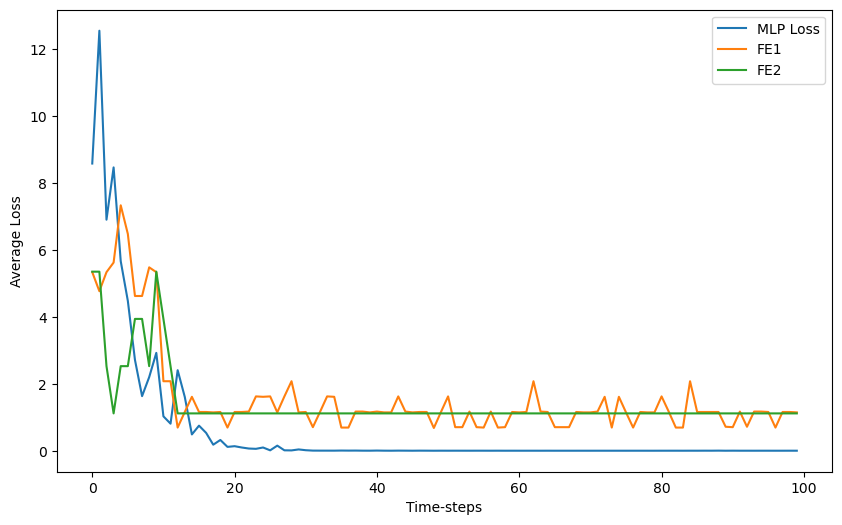

In [11]:
mlp = MLP()
criterion = nn.MSELoss()
optimizer = Adam(mlp.parameters(), lr=0.01)
train_and_cal(10,90)

In [12]:
print(w2vinf.wv['mama'])
print(w2vinf.wv['cat'])
print(w2vinf.wv['ball'])
print(mlp(torch.tensor([1,0,0], dtype=torch.float).unsqueeze(0)),"\n", mlp(torch.tensor([0,1,0], dtype=torch.float).unsqueeze(0)),"\n", mlp(torch.tensor([0,0,1], dtype=torch.float).unsqueeze(0)))

[0.        4.5643225 2.2844782]
[4.0016165 5.        0.8598008]
[5. 0. 0.]
tensor([[1.0181e-03, 4.5935e+00, 2.3029e+00]], grad_fn=<AddmmBackward0>) 
 tensor([[4.0136, 5.0165, 0.8716]], grad_fn=<AddmmBackward0>) 
 tensor([[5.0100, 0.0065, 0.0104]], grad_fn=<AddmmBackward0>)
